## **Input Embedding**

```tokens``` : sentences are broken down to words or sub-words

```input_ids``` : each token has an index in the ```vocabulary``` we identify any new token by these ids

```embed_tokens``` : This refers to the embedding layer of the model. Each ```input_ids``` is converted into an n-dimensional dense vector (of size ```embed_dim or hidden_sz```). These vectors capture semantic relationships between tokens

During training or inference, multiple sequences (sentences) are grouped into a ```batch```. Each token in a sequence is converted to its corresponding embedding vector, and the model processes these batches in parallel for efficiency.


**Tokenization and Embedding**

1.  **Tokenization:** First, we tokenize each sentence, breaking it down into individual words or subwords (tokens).

    * Sentence 1: `["The", "cat", "sat", "on", "the", "mat", "."]`
    * Sentence 1 (padded): `["The", "cat", "sat", "on", "the", "mat", ".", "<PAD>"]`
    * Sentence 2: `["Dogs", "bark", "loudly", "at", "night", "."]`
    * Sentence 2 (padded): `["Dogs", "bark", "loudly", "at", "night", ".", "<PAD>", "<PAD>"]`
    * Sentence 3: `["Birds", "fly", "high", "in", "the", "sky", "."]`

    Now, each padded sentence has 8 tokens.

2.  **Embedding:** Next, each token is converted into a numerical vector called an embedding. These embeddings represent the semantic meaning of the words. Let's assume we have a vocabulary and an embedding layer that maps each word to a 5-dimensional vector. For simplicity, we'll represent these vectors as placeholders.

    * "The" -> `[0.1, 0.2, 0.3, 0.4, 0.5]`
    * "cat" -> `[0.6, 0.7, 0.8, 0.9, 1.0]`
    * "sat" -> `[1.1, 1.2, 1.3, 1.4, 1.5]`
    * ...and so on for all the words.




3.  **Batch Matrix:** Finally, we arrange the embedded vectors into a 3D tensor (a matrix of matrices):

    * Batch shape: `(batch_size, sequence_length, embedding_dimension)`
    * In our case: `(3, 8, 5)`

    This 3D tensor represents the entire batch of embedded sequences.


## **Positional Encoding**

These encodings are vectors that keep the location of a word in the sentence & helps the model understand the order and context of words in the sentence (since it lacks the recurrence feature found in RNNs to feed the input one at a time) Currently in models like Mistral ```RotaryEmbedding``` (a type of Dynamic positional encoding) is used inside ```self_attn``` block

## **Self-Attention Mechanism**

It calculates a weighted sum of the embeddings of all words in a sentence for each word. These weights are determined based on some learned “attention” scores between words. The terms with higher relevance to one another will receive higher “attention” weights.

**Query Vector**:

  - It represents the word or token for which the attention weights are being calculated.
  - The Query vector determines which parts of the input sequence should receive more attention.
  - Multiplying word embeddings with the Query vector is like asking, **"What should I pay attention to?"**

**Key Vector**:

  - It represents the set of words or tokens in the input sequence that are compared with the Query.
  - The Key vector helps identify the relevant or essential information in the input sequence.
  - Multiplying word embeddings with the Key vector is like asking, **"What is important to consider?"**

**Value Vector**:

- It contains the input sequence's associated information or features for each word or token.
- The Value vector provides the actual data that will be weighted and combined based on the attention weights calculated between the Query and Key.
- The Value vector answers the question, **"What information do we have?"**

**Attention Weights/Scores** : Calculated for each token and head.Each element represents the attention a particular head pays to a specific token when processing the input.

**Attention Output** : Combine the weights with the original input. It incorporates information from relevant tokens based on the attention scores, enriching each token's representation.

# **Transformer**

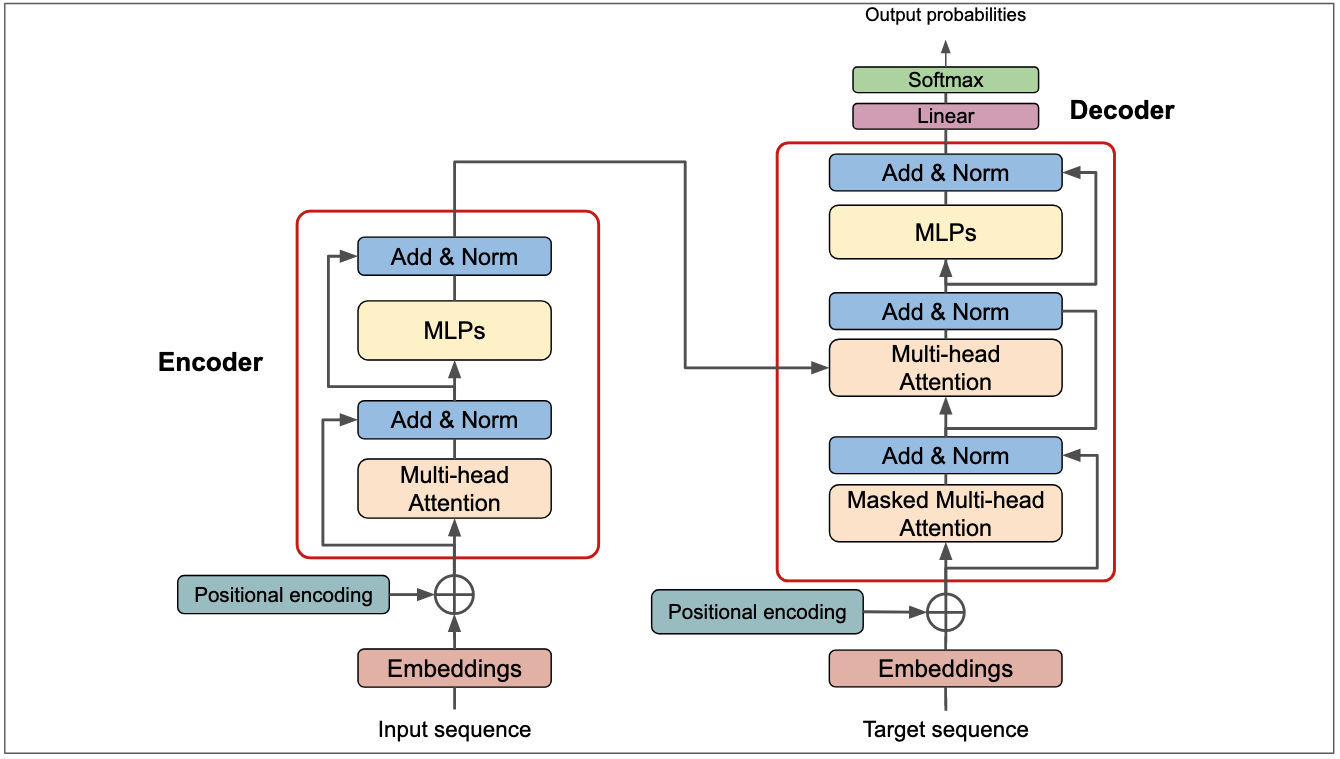

# SparseAttention
https://github.com/kyegomez/SparseAttention


# FlashAttention

https://github.com/kyegomez/FlashAttention20




## **Self-Attention vs Cross-Attention**

**What is the difference between Self-Attention and Cross-Attention?**

They are actually very similar! The self-attention computes the interactions between the different elements of an input sequence (for example, the different words in a sentence), and the cross-attention computes the interactions between the elements of 2 different input sequences (for example, how words in one sentence influence words of another sentence).


Encoder part of transformer has Multi-Headed Self-Attention & the part connecting Encoder output Decoder hidden state in Decoder part of transformer is Multi-Headed Cross-Attention


## **GQA,MQA,MHA**

MQA uses a single set of key-value pairs for all queries, drastically speeding up computation but potentially sacrificing accuracy, whereas GQA groups queries together, allowing for multiple key-value sets within a group, striking a balance between speed and quality by interpolating between MQA and full multi-head attention (MHA)



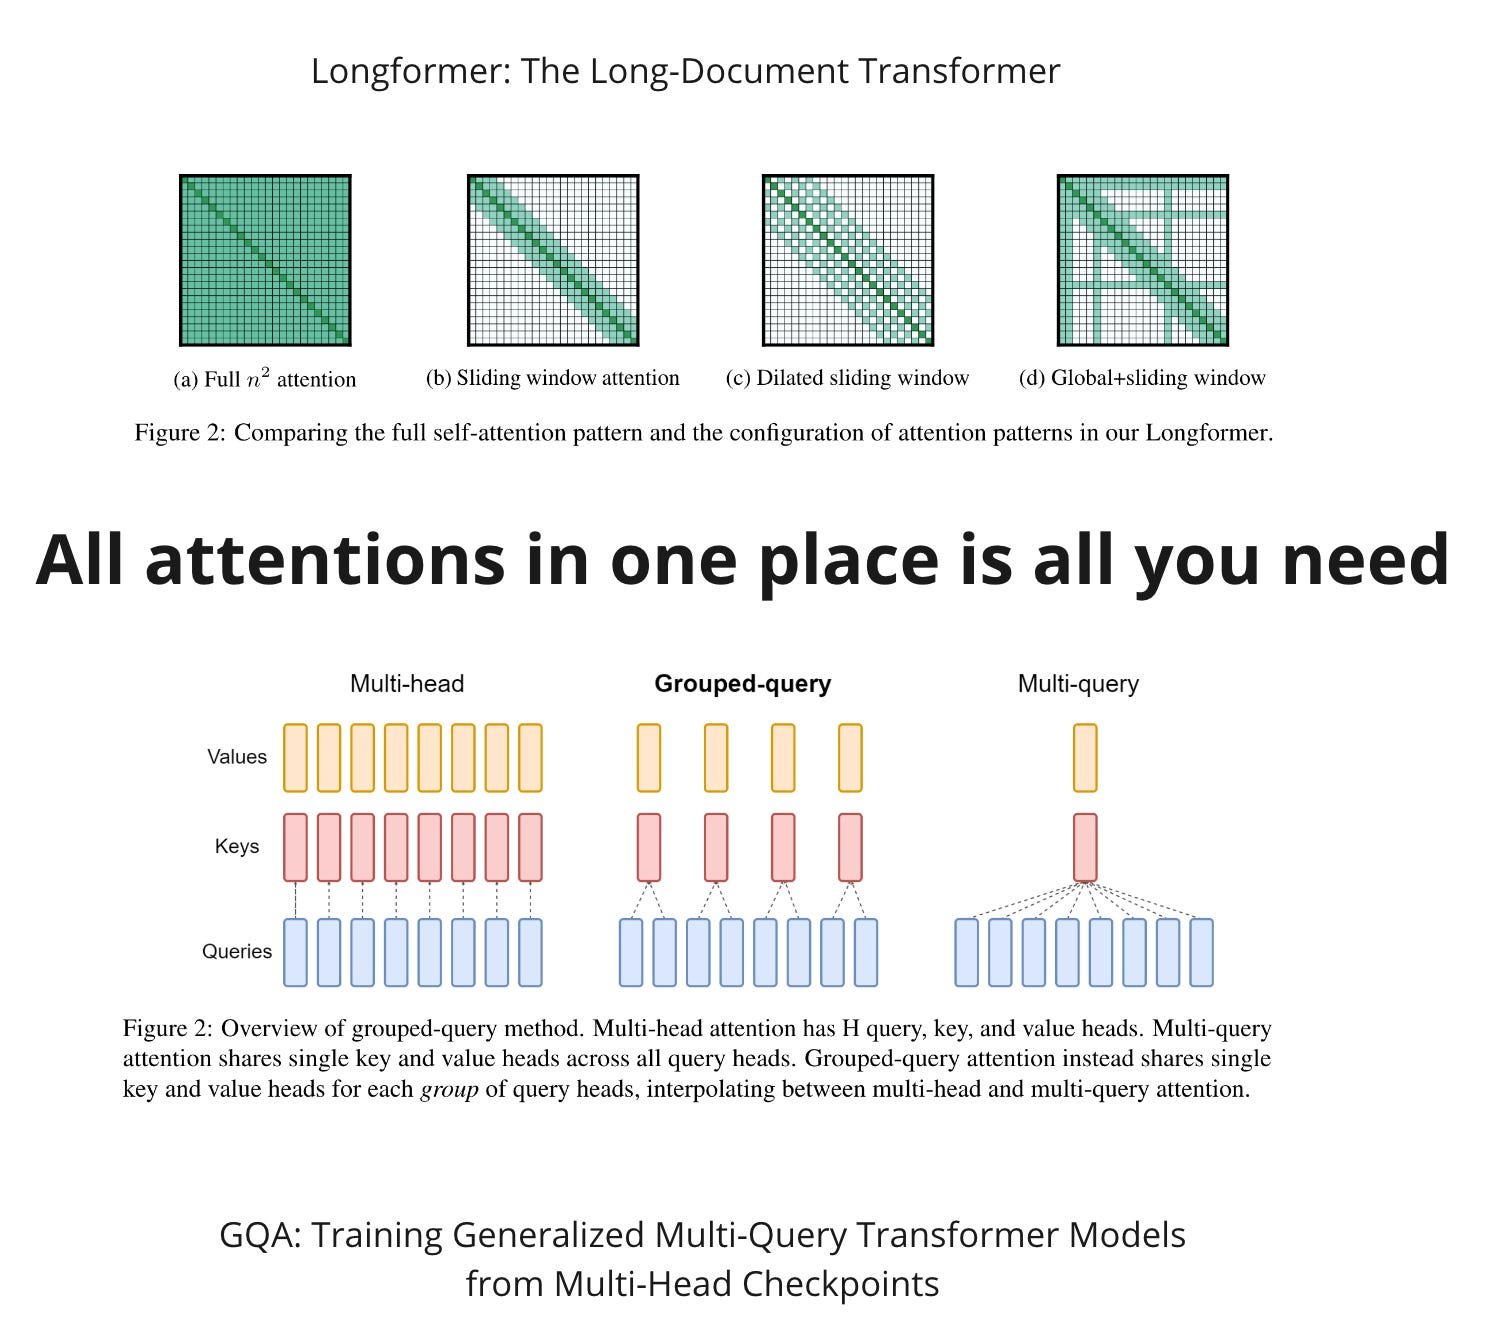

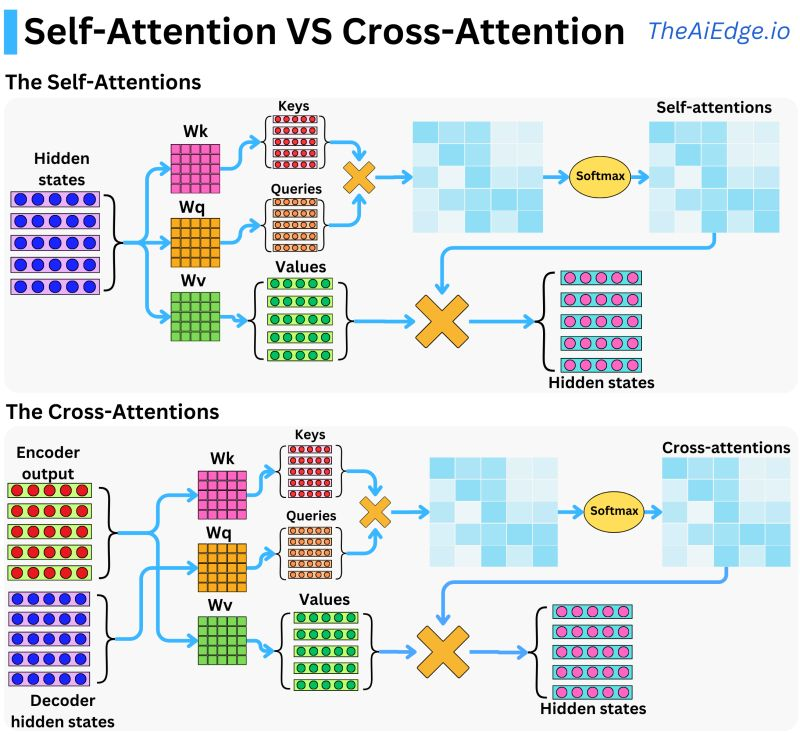

In [ ]:
"""
Dimension key:

B: batch size
L: sequence length
M: memory length (length of sequence being attended to)
D: model dimension (sometimes called d_model or embedding_dim)
V: vocabulary size
F: feed-forward subnetwork hidden size
H: number of attention heads in a layer
K: size of each attention key or value (sometimes called d_kv)
"""

## Why we need KV-cache


https://fireworks.ai/blog/multi-query-attention-is-all-you-need



```python
import torch
import math

N = 1 # batch sz
H = 32 # number of "heads" in the operation
S,L = 10,15 # input and output sequence lengths
D = 4096 # hidden_dim / embedding_dim

Q_NHSD = torch.randn(N,H,S,D)
K_NHLD = torch.randn(N,H,L,D)
V_NHLD = torch.randn(N,H,L,D)

logits_NHSL = torch.matmul(Q_NHSD,K_NHLD.transpose(2,3))
softmax_out_NHSL = torch.softmax(logits_NHSL/math.sqrt(D),dim=3)
atten_out_NHSD = torch.matmul(softmax_out_NHSL,V_NHLD)
```



In [ ]:
# import torch
# import math

# N = 1 # batch sz
# h = 32 # number of "heads" in the operation
# S,L = 10,15 # input and output sequence lengths
# d_k = 4096 # hidden_dim / embedding_dim

# Q = torch.randn(N, h, S, d_k)
# K = torch.randn(N, h, L, d_k)
# V = torch.randn(N, h, L, d_k)


# # <...>

# logits = torch.matmul(Q, K.transpose(2, 3)) # Output shape [N, h, S, L]
# softmax_out = torch.softmax(logits / math.sqrt(d_k), dim=-1) # Output shape [N, h, S, L]
# attn_out = torch.matmul(softmax_out, V) # Output shape [N, h, S, d_k]


Note that we have two sequence lengths: one that applies to our Q value and one that applies to both K and V values. During inference, we typically use incremental generation, where we progressively feed values into the network a single token at a time (i.e. S = 1) and compute K and V across the tokens seen so far (i.e. L grows as generation proceeds). As a result, K and V grow progressively as the output sequence is generated, and a common optimization technique is to use a mutable **KV-cache** across iterations. The inner loop of multi-head attention then looks like this

In [ ]:
# Cached K and V values across iterations
K = torch.randn(N, H, L+3, D)
V = torch.randn(N, H, L+3, D)

# Single-step QKV values computed during sequence generation
Q_incr = torch.randn(N, H, 1, D)
K_incr = torch.randn(N, H, 1, D)
V_incr = torch.randn(N, H, 1, D)

# <...>

# Update KV-cache
K = torch.cat([K, K_incr], dim=-2)
V = torch.cat([V, V_incr], dim=-2)

# Compute attention (L is sequence length so far)
logits = torch.matmul(Q_incr, K.transpose(2, 3)) # Output shape [N, H, 1, L]
softmax_out = torch.softmax(logits / math.sqrt(D), dim=-1) # Output shape [N, H, 1, L]
attn_out = torch.matmul(softmax_out, V) # Output shape [N, H, 1, D]


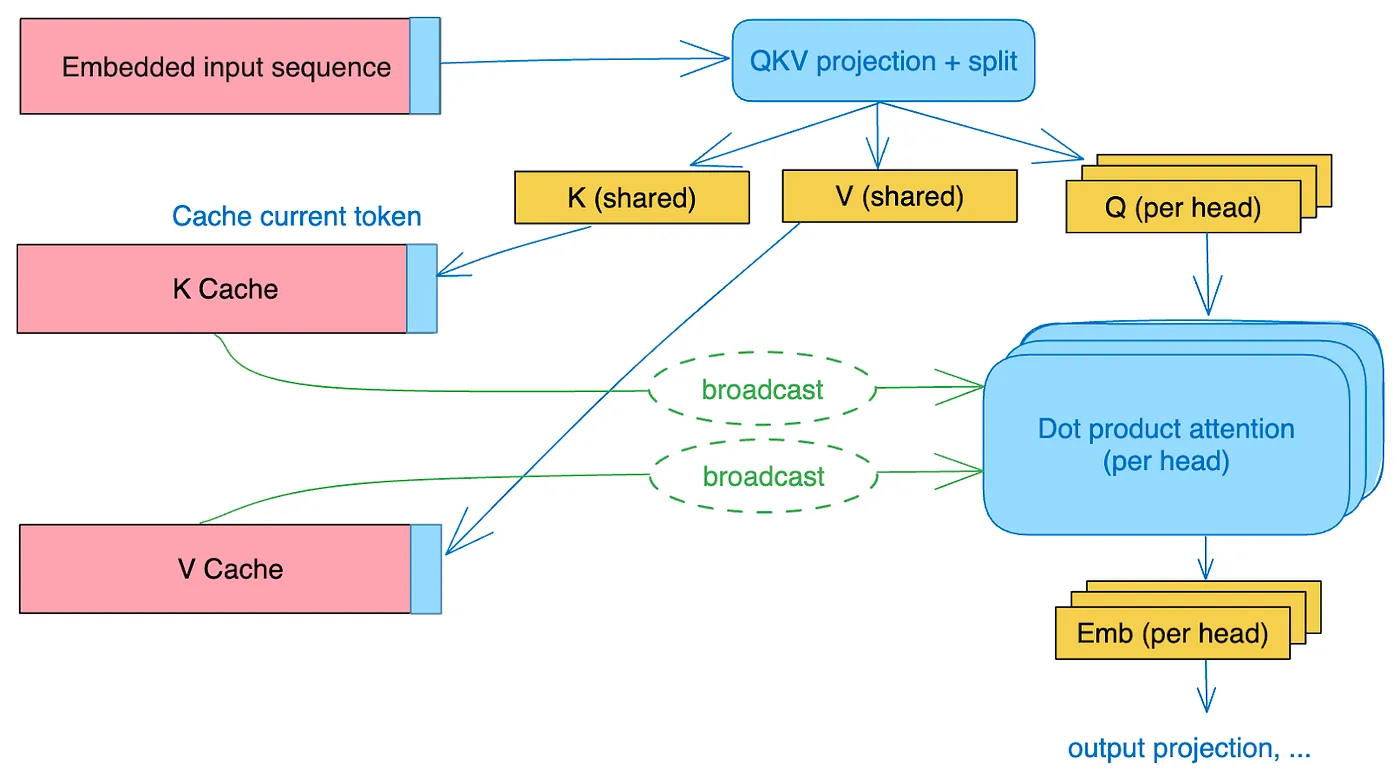

The idea is simple: remove (or otherwise greatly reduce) the heads dimension h from the K and V values. Intuitively, we can say that in multi-head attention, the entire attention computation is replicated h times, whereas in multi-query attention, each “head” of the query value Q has the same K and V transformation applied to it.

In [ ]:
# Cached K and V values across iterations
K = torch.randn(N, H, L+3, D)
V = torch.randn(N, H, L+3, D)

# Single-step QKV values computed during sequence generation
Q_incr = torch.randn(N, H, 1, D)
K_incr = torch.randn(N, 1, d_k)
V_incr = torch.randn(N, 1, d_k)

# <...>

# Update KV-cache
# Expand K_incr and V_incr to have the same number of dimensions as K and V
K_incr = K_incr.unsqueeze(1).expand(N, h, 1, d_k) # New shape [N, h, 1, d_k]
V_incr = V_incr.unsqueeze(1).expand(N, h, 1, d_k) # New shape [N, h, 1, d_k]

K = torch.cat([K, K_incr], dim=-2)
V = torch.cat([V, V_incr], dim=-2)

# Compute attention (L is sequence length so far)
# NB: K is broadcasted (repeated) out across Q's \`h\` dimension!
logits = torch.matmul(Q_incr, K.transpose(2, 3)) # Output shape [N, h, 1, L\]
softmax_out = torch.softmax(logits / math.sqrt(d_k), dim=-1) # Output shape [N, h, 1, L]
# NB: V is broadcasted (repeated) out across softmax_out's `h` dimension!
attn_out = torch.matmul(softmax_out, V) # Output shape [N, h, 1, d_k]


**Model Structure**: The code assumes the model has a modular structure, typically found in transformer models.

**Layer Access**: Accessing and replacing layers depends on the model’s architecture. For instance, in BERT, you access encoder layers through model.encoder.layer, while in GPT or OPT, you might need to adjust according to the specific layer structure.

**Modification Scope**: This method can be adapted to replace other components like feed-forward layers, normalization layers, etc.

**Model-Specific Adjustments**: The exact implementation may vary based on the model. For instance, GPT models use transformer.h instead of encoder.layer

In [ ]:
# import torch
# import torch.nn as nn
# from transformers import BertModel

# class CustomAttention(nn.Module):
#     def __init__(self, embed_dim, num_heads):
#         super(CustomAttention, self).__init__()
#         self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads)

#     def forward(self, hidden_states, attention_mask=None, head_mask=None, encoder_hidden_states=None,
#                 encoder_attention_mask=None, past_key_value=None, output_attentions=False):
#         # Use the multihead_attention module to perform the attention operation
#         return self.multihead_attention(hidden_states, hidden_states, hidden_states,
#                                         attn_mask=attention_mask, key_padding_mask=attention_mask)[0]


# Encoder only Architecture - BERT

The model is comprised of both encoder and decoder components, with each component consisting of 12 layers. Additionally, The decoder component, in particular, contains an additional encoder_attn layer, referred to as cross-attention. The cross-attention component will condition the decoder’s output based on the encoder representations.

```python
BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=3072, out_features=768, bias=True)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
  )
)
```


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, GPT2Model

# def print_trainable_parameters(model):
#     total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#     print(f"Total Trainable Parameters: {total_params}")

gpt2 = AutoModel.from_pretrained("gpt2")


def prepare_for_peft(model):
    for param in model.parameters():
        param.requires_grad = False  # freeze the model - train adapters later
        if param.dim() == 1:
            # cast the small parameters (e.g. layernorm) to fp32 for stability
            param.data = param.data.to(torch.float32)

    # Commented this line because it's not a valid function for GPT2Model
    # model.gradient_checkpointing_enable()  # reduce number of stored activations

    model.config.gradient_checkpointing = True  # enable gradient checkpointing
    model.config.use_cache = False  # disable cache for memory efficiency
    model.config.output_hidden_states = False  # set to True if you want hidden states
    model.config.output_attentions = False  # set to True if you want attention weights

    # No need to define a separate class, we can use nn.Sequential directly
    model.lm_head = nn.Sequential(nn.Linear(model.config.hidden_size, model.config.vocab_size))
    return model


gpt2 = prepare_for_peft(gpt2)




config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

```python

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)
trainable params: 124439808 || all params: 124439808 || trainable%: 100.0

now after preparing for peft a lm_head is added with above model & only part of it is trained

GPT2Model(
  (lm_head): Sequential(
    (0): Linear(in_features=768, out_features=50257, bias=True)
  )
)
trainable params: 38647633 || all params: 163087441 || trainable%: 23.697491825872724

```

# Local Attention & Global Attention

https://github.com/lucidrains/local-attention


### Local vs Global Attention

**Local Attention** focuses on a subset of the input sequence within a fixed-size window, offering computational efficiency by reducing the scope of attention. It’s useful in tasks like language modeling and image processing, where nearby context is more relevant.

**Global Attention** considers all positions of the input, providing a comprehensive view of the entire sequence. It’s more resource-intensive but excels in capturing long-range dependencies, such as in machine translation or image classification.

It is becoming apparent that a transformer needs local attention in the bottom layers, with the top layers reserved for global attention to integrate the findings of previous layers. This repository makes it easy to immediately employ local window attention.


In [ ]:
import torch
import torch.nn as nn

class SparseAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, window):
        super(SparseAttention, self).__init__()
        self.head_dim = embed_dim // num_heads
        self.num_heads = num_heads
        self.window = window
        self.q_proj = nn.Linear(input_dim, embed_dim)
        self.k_proj = nn.Linear(input_dim, embed_dim)
        self.v_proj = nn.Linear(input_dim, embed_dim)
        self.output_proj = nn.Linear(embed_dim, input_dim)

    def _create_local_attention_mask(self, seq):
        mask = torch.zeros(seq, seq, dtype=torch.bool)  # [seq, seq]
        for i in range(seq):
            start = max(0, i - self.window // 2)
            end = min(seq, i + self.window // 2 + 1)
            mask[start:end, i] = 1
        mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq, seq]
        return mask

    def forward(self, x, local_attn=False):
        batch_size, seq_len, embed_dim = x.size() # [batch,seq_len,head_dim * num_heads]
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # Reshape and transpose for multi-head attention
        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # [batch, num_heads, seq_len, head_dim]
        k = k.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # [batch, num_heads, seq_len, head_dim]
        v = v.reshape(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # [batch, num_heads, seq_len, head_dim]

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # [batch, num_heads, seq_len, seq_len]

        if local_attn:
            mask = self._create_local_attention_mask(seq_len)
            attn_scores = attn_scores.masked_fill(mask, float('-inf'))

        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)  # [batch, num_heads, seq_len, head_dim]

        attn_output = attn_output.transpose(1, 2).reshape(batch_size, seq_len, embed_dim)  # [batch, seq_len, embed_dim]
        attn_output = self.output_proj(attn_output)

        return attn_output, attn_weights

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.model = AutoModelForCausalLM.from_pretrained('facebook/opt-350m')
        self._replace_attention_layer() # can add more custom layers like this

    def _replace_attention_layer(self):
        for name, module in self.model.named_modules():
            if isinstance(module, nn.MultiheadAttention):
                # Extract parameters from the existing module
                input_dim = module.embed_dim
                num_heads = module.num_heads
                # Create and replace the attention layer
                new_attention_layer = SparseAttention(
                    input_dim=input_dim,
                    embed_dim=input_dim,
                    num_heads=num_heads,
                    window=4,  # Example window size

                )
                setattr(self.model, name, new_attention_layer)

    def forward(self,*args, local_attn=False, **kwargs):
        return self.model(*args,**kwargs)




In [ ]:

# Tokenization and Model Execution
tokenizer = AutoTokenizer.from_pretrained('facebook/opt-350m')
inputs = tokenizer("If you modify the model",return_tensors='pt')
print(inputs.items())

dict_items([('input_ids', tensor([[    2,  1106,    47, 23209,     5,  1421]])), ('attention_mask', tensor([[1, 1, 1, 1, 1, 1]]))])


In [ ]:
def create_local_attention_mask(seq,window = 3):
        mask = torch.zeros(seq, seq, dtype=torch.bool)  # [seq, seq]
        for i in range(seq):
            start = max(0, i - window // 2)
            end = min(seq, i + window // 2 + 1)
            mask[start:end, i] = 1
        mask = mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq, seq]
        return mask

# window = 3
seq = inputs["input_ids"][0].shape[0]
mask = create_local_attention_mask(seq)
print(seq)
print(mask)

6
tensor([[[[ True,  True, False, False, False, False],
          [ True,  True,  True, False, False, False],
          [False,  True,  True,  True, False, False],
          [False, False,  True,  True,  True, False],
          [False, False, False,  True,  True,  True],
          [False, False, False, False,  True,  True]]]])


### Next Word Prediction

In [ ]:
model = CustomModel()
outputs = model(**inputs, local_attn=True)


logits = outputs.logits  # Raw logits (scores for each token in the vocabulary)
hidden_states = outputs.hidden_states  # Optional, if return_dict=True and output_hidden_states=True
attention_weights = outputs.attentions  # Optional, if return_dict=True and output_attentions=True
predicted_token_ids = torch.argmax(logits, dim=-1)  # [batch, seq]
decoded_output = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
print("Logits shape(Custom model):", logits.shape) # [batch_size, seq_length, vocab_size]
print("Decoded output(Custom model):", decoded_output)

print("="*100)

base_model = AutoModelForCausalLM.from_pretrained('facebook/opt-350m')
base_outputs = base_model(**inputs)
logits_base_model = base_outputs.logits
pred_token_id_base_model = torch.argmax(logits_base_model ,dim=-1)
decoded_output_base_model = tokenizer.batch_decode(pred_token_id_base_model, skip_special_tokens=True)
print("Logits shape(Base model):", logits_base_model .shape)
print("Decoded output(Base model):", decoded_output_base_model)

Logits shape(Custom model): torch.Size([1, 6, 50272])
Decoded output(Custom model): ["\n you're the game,"]
Logits shape(Base model): torch.Size([1, 6, 50272])
Decoded output(Base model): ["\n you're the game,"]


In [ ]:
#